## Simulating melts of polymer chains

In [1]:
import warnings
warnings.filterwarnings('ignore')
import hoomd
import gsd
import gsd.hoomd
from hoomd.md import nlist

import unyt as u
import glob
import mbuild as mb
import matplotlib.pyplot as plt
import numpy as np

import flowermd
from flowermd.utils import get_target_box_mass_density
from flowermd.base import Simulation, Molecule
from flowermd.library import FF_from_file
from flowermd.base.system import Pack

from polymer_dictionary import bond_indices

# Rerun with the original seed first

In [2]:
# Updates atom names to fit with hoomd conventions
def espaloma_mol(file_path):
     mol = mb.load(file_path)
     for p in mol.particles():
           p.name = f"_{p.name}"
     return mol

## Single molecule sim:

In [33]:
system_file = '/home/jbieri/d/pl-validation/fixed_PCPDTPT_nC16_2mer.mol2'
# system_file = '/home/jbieri/CME_lab/repos/pl-validation/mol2/fixed_PCPDTPT_nC16.mol2'
ff_filepath = '/home/jbieri/CME_lab/repos/pl-validation/xml/fixed_PCPDTPT_nC16.xml'

espmol = espaloma_mol(system_file)
molecule = Molecule(num_mols=1, compound=espmol)

molff = FF_from_file(ff_filepath)
system = Pack(molecules=molecule,density=0.01 * u.g/u.cm**3,packing_expand_factor=5)
system.apply_forcefield(r_cut=2.5, force_field=molff, auto_scale=True,remove_charges=True, remove_hydrogens=True)

ParameterizationError: No parameters found for connection <Dihedral Dihedral, id: 139782495820992> , group: dihedral_type, identifiers: [['S1', 'C0', 'C0', 'H4'], ['S1', 'C0', 'C0', 'H4']] in the Forcefield.

In [8]:
system.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
system.hoomd_snapshot
hoomd_forces = system.hoomd_forcefield
hoomd_forces
lj_force = hoomd_forces[3]
cpu = hoomd.device.CPU()
sim = Simulation.from_system(system=system, gsd_write_freq=10, log_write_freq=10, device=cpu, gsd_file_name='fixed_PCPDTPT_nC16_melt.gsd',log_file_name="fixed_log.txt")

Initializing simulation state from a gsd.hoomd.Frame.


In [5]:
target_box = flowermd.utils.get_target_box_mass_density(density=0.02 * u.g/u.cm**3, mass=sim.mass.to("g"))
sim.run_update_volume(n_steps=1e4, kT=1.0, tau_kt=1.0, final_box_lengths=target_box, period=10)

Step 10 of 10000; TPS: 39.62; ETA: 4.2 minutes
Step 20 of 10000; TPS: 78.93; ETA: 2.1 minutes
Step 30 of 10000; TPS: 118.06; ETA: 1.4 minutes
Step 40 of 10000; TPS: 156.98; ETA: 1.1 minutes
Step 50 of 10000; TPS: 195.69; ETA: 0.8 minutes
Step 60 of 10000; TPS: 234.03; ETA: 0.7 minutes
Step 70 of 10000; TPS: 272.3; ETA: 0.6 minutes
Step 80 of 10000; TPS: 310.4; ETA: 0.5 minutes
Step 90 of 10000; TPS: 348.24; ETA: 0.5 minutes
Step 100 of 10000; TPS: 385.96; ETA: 0.4 minutes
Step 110 of 10000; TPS: 423.41; ETA: 0.4 minutes
Step 120 of 10000; TPS: 460.74; ETA: 0.4 minutes
Step 130 of 10000; TPS: 497.94; ETA: 0.3 minutes
Step 140 of 10000; TPS: 534.94; ETA: 0.3 minutes
Step 150 of 10000; TPS: 571.71; ETA: 0.3 minutes
Step 160 of 10000; TPS: 608.37; ETA: 0.3 minutes
Step 170 of 10000; TPS: 644.34; ETA: 0.3 minutes
Step 180 of 10000; TPS: 679.68; ETA: 0.2 minutes
Step 190 of 10000; TPS: 714.98; ETA: 0.2 minutes
Step 200 of 10000; TPS: 750.75; ETA: 0.2 minutes
Step 210 of 10000; TPS: 767.4; ET

In [6]:
sim.run_NVT(n_steps=1e4, kT=5.0, tau_kt=1.0)
sim.flush_writers()

Step 9 of 10000; TPS: 5572.76; ETA: 0.0 minutes
Step 19 of 10000; TPS: 6916.64; ETA: 0.0 minutes
Step 29 of 10000; TPS: 7092.2; ETA: 0.0 minutes
Step 39 of 10000; TPS: 8099.69; ETA: 0.0 minutes
Step 49 of 10000; TPS: 8846.36; ETA: 0.0 minutes
Step 59 of 10000; TPS: 9446.05; ETA: 0.0 minutes
Step 69 of 10000; TPS: 9433.96; ETA: 0.0 minutes
Step 79 of 10000; TPS: 9436.22; ETA: 0.0 minutes
Step 89 of 10000; TPS: 9405.05; ETA: 0.0 minutes
Step 99 of 10000; TPS: 9377.66; ETA: 0.0 minutes
Step 109 of 10000; TPS: 9443.77; ETA: 0.0 minutes
Step 119 of 10000; TPS: 9439.2; ETA: 0.0 minutes
Step 129 of 10000; TPS: 9399.59; ETA: 0.0 minutes
Step 139 of 10000; TPS: 9382.38; ETA: 0.0 minutes
Step 149 of 10000; TPS: 9344.04; ETA: 0.0 minutes
Step 159 of 10000; TPS: 9297.16; ETA: 0.0 minutes
Step 169 of 10000; TPS: 9298.49; ETA: 0.0 minutes
Step 179 of 10000; TPS: 9402.25; ETA: 0.0 minutes
Step 189 of 10000; TPS: 9517.1; ETA: 0.0 minutes
Step 199 of 10000; TPS: 9528.83; ETA: 0.0 minutes
Step 209 of 10

In [3]:
# system_file = '/home/jbieri/d/pl-validation/fixed_PCPDTPT_nC16_2mer.mol2'
system_file = '/home/jbieri/CME_lab/repos/pl-validation/mol2/fixed_PCPDTPT_nC16.mol2'
ff_filepath = '/home/jbieri/CME_lab/repos/pl-validation/xml/fixed_PCPDTPT_nC16.xml'

espmol = espaloma_mol(system_file)
molecule = Molecule(num_mols=5, compound=espmol)

molff = FF_from_file(ff_filepath)
system = Pack(molecules=molecule,density=0.01 * u.g/u.cm**3,packing_expand_factor=5)
system.apply_forcefield(r_cut=2.5, force_field=molff, auto_scale=True,remove_charges=True, remove_hydrogens=True)

No charged group detected, skipping electrostatics.


In [4]:
system.hoomd_snapshot
hoomd_forces = system.hoomd_forcefield
hoomd_forces
lj_force = hoomd_forces[3]
cpu = hoomd.device.CPU()
sim = Simulation.from_system(system=system, gsd_write_freq=5000, log_write_freq=5000, device=cpu, gsd_file_name='fixed_PCPDTPT_nC16_melt.gsd',log_file_name="fixed_log.txt")

Initializing simulation state from a gsd.hoomd.Frame.


In [5]:
target_box = flowermd.utils.get_target_box_mass_density(density=0.02 * u.g/u.cm**3, mass=sim.mass.to("g"))
sim.run_update_volume(n_steps=1e4, kT=1.0, tau_kt=1.0, final_box_lengths=target_box, period=10)

Step 5000 of 10000; TPS: 3646.32; ETA: 0.0 minutes
Step 10000 of 10000; TPS: 4029.49; ETA: 0.0 minutes


In [6]:
sim.run_NVT(n_steps=1e7, kT=5.0, tau_kt=1.0)
sim.flush_writers()

Step 4999 of 10000000; TPS: 4126.86; ETA: 40.4 minutes
Step 9999 of 10000000; TPS: 4457.09; ETA: 37.4 minutes
Step 14999 of 10000000; TPS: 4513.96; ETA: 36.9 minutes
Step 19999 of 10000000; TPS: 4600.3; ETA: 36.2 minutes
Step 24999 of 10000000; TPS: 4086.4; ETA: 40.7 minutes
Step 29999 of 10000000; TPS: 4163.85; ETA: 39.9 minutes
Step 34999 of 10000000; TPS: 4253.84; ETA: 39.0 minutes
Step 39999 of 10000000; TPS: 4315.96; ETA: 38.5 minutes
Step 44999 of 10000000; TPS: 4380.2; ETA: 37.9 minutes
Step 49999 of 10000000; TPS: 4429.94; ETA: 37.4 minutes
Step 54999 of 10000000; TPS: 4472.59; ETA: 37.1 minutes
Step 59999 of 10000000; TPS: 4505.7; ETA: 36.8 minutes
Step 64999 of 10000000; TPS: 4513.85; ETA: 36.7 minutes
Step 69999 of 10000000; TPS: 4549.34; ETA: 36.4 minutes
Step 74999 of 10000000; TPS: 4568.63; ETA: 36.2 minutes
Step 79999 of 10000000; TPS: 4596.3; ETA: 36.0 minutes
Step 84999 of 10000000; TPS: 4611.73; ETA: 35.8 minutes
Step 89999 of 10000000; TPS: 4639.18; ETA: 35.6 minutes

In [24]:
data = np.genfromtxt("fixed_log.txt", names=True)
pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
ke = data["mdcomputeThermodynamicQuantitieskinetic_energy"]
ts = data["flowermdbasesimulationSimulationtimestep"]

In [28]:
print(ts)

[0.0000e+00 5.0000e+03 1.0000e+04 ... 1.0000e+07 1.0005e+07 1.0010e+07]


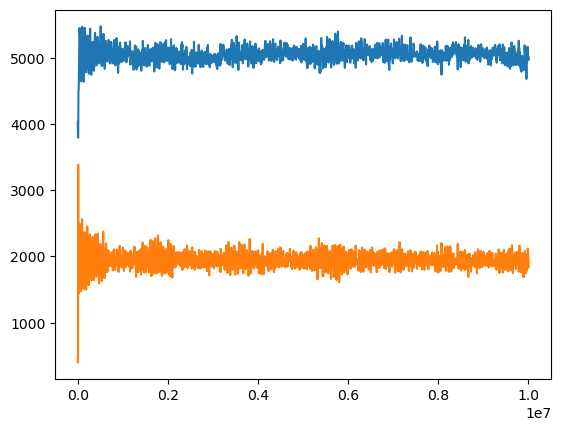

In [32]:
plt.plot(ts,pe)
# plt.xlim(0,10000)
plt.plot(ts,ke)

## Running simulations across all polymers:

In [3]:
# Sorted list of polymer mol2 and xml files so they're in the same order (change number of mers here)
molecule_list = sorted(glob.glob("/home/jbieri/CME_lab/repos/pl-validation/mol2/10_mers/"+"*.mol2"))
ff_list = sorted(glob.glob("/home/jbieri/CME_lab/repos/pl-validation/xml/"+"*.xml"))

In [5]:
# Sorting and printing polymer names in the same order as above (alphabetical)
key_list = sorted(list(bond_indices.keys()))
print(key_list)
print(len(key_list))

['PCPDTFBT_C11_BO', 'PCPDTFBT_C1_BO', 'PCPDTFBT_C3_BO', 'PCPDTFBT_C4_BO', 'PCPDTFBT_C5_BO', 'PCPDTPT_HD', 'PCPDTPT_ODD', 'PCPDTPT_eneODD', 'PCPDTPT_nC16', 'PCPDT_PT_eneHD', 'PIDTBT_nC16', 'PIDTCPDT_C11BO', 'PIDTFBT_C11_BO']
13


In [8]:
# Ensure mer folder matches number of mers in the chains
for i in range(len(molecule_list)):
    print(key_list[i]) # Check name of polymer
    system_file = molecule_list[i]
    ff_filepath = ff_list[i]
    espmol = espaloma_mol(system_file) # Ensuring atom types are sim readable 
    molecule = Molecule(num_mols=1, compound=espmol)
    molff = FF_from_file(ff_filepath)
    system = Pack(molecules=molecule,density=bond_indices.get(key_list[i]).get("Density")* u.g/u.cm**3,packing_expand_factor=5)
    system.apply_forcefield(r_cut=2.5, force_field=molff, auto_scale=True,remove_charges=True, remove_hydrogens=True)
    sim = Simulation.from_system(system=system, gsd_write_freq=1000, log_write_freq=1000, device=cpu, gsd_file_name=("/home/jbieri/CME_lab/repos/pl-validation/gsd_files/10_mers/"+key_list[i]+"_melt.gsd"))
    sim.run_NVT(n_steps=1e5, kT=5.0, tau_kt=1.0)
    sim.flush_writers()

PIDTFBT_C11_BO


FoyerError: Found no types for atom numbered 23 which is atomic number None. Forcefield file is missing this atomtype, so try to add SMARTS definitions to account for this atom.